## Lake Zug APhys-AChem Meeting (24/11/2025)

In [266]:
# imports
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings('ignore')
#%matplotlib qt
%matplotlib inline

### Field Work -- CTD Transects

In [267]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [268]:
# planned locations
profile_locs = pd.DataFrame({
    'loc': [f'P{x}' for x in range(1, 13)],
    'xsc': [679803, 679803, 679663, 679415, 679505, 680030, 680150, 680223, 680409, 680814, 681350, 681909],
    'ysc': [224100, 222690, 221650, 220433, 219544, 218872, 218462, 218126, 217437, 216239, 214957, 213760]
})

profile_locs['xsc'] += int(2e6)
profile_locs['ysc'] += int(1e6)

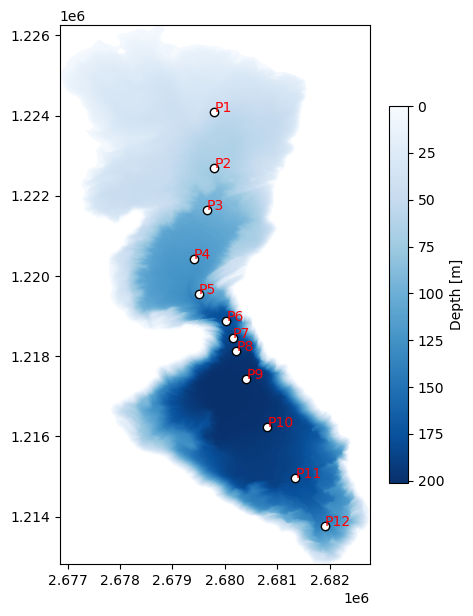

In [269]:
fig, ax = plt.subplots(figsize=(5, 7))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# planned locations
for _, row in profile_locs.iterrows():
    ax.scatter(row.xsc, row.ysc, c='white', edgecolor='black')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red')

plt.show()

In [270]:
root = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/VerticalProfiles/to_be_processed/'
data_dirs = ['20251030', '20251107', '20251114', '20251121']

In [271]:
def locate_files(root, data_dir, ext):
    dpath = os.path.join(root, data_dir)
    md_files = glob(os.path.join(dpath, '*.meta'))

    profiles = []
    for mdf in md_files:
        fpath, _ = os.path.splitext(mdf)
        profiles.append(f'{fpath}.{ext}')

    return md_files, profiles


def parse_profiles_RBR(md_files, profiles, bathy):
    data = {}
    for md_file, profile in tqdm(zip(md_files, profiles)):
        with open(md_file, 'r') as f:
            md = json.load(f)

        i = int(md['profile']['Profile name'][1:]) - 1
        xsc = int(md['profile']['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(md['profile']['Y Coordinate (CH1903)']) + int(1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        ds = xr.open_dataset(profile)

        # select downcast
        bottom_idx = np.argmax(ds.depth.values)
        ds = ds.isel(timestamp=slice(0, bottom_idx + 1))

        # remove air
        air_idx = np.where(ds.depth.values < 0)[0][-1]
        ds = ds.isel(timestamp=slice(air_idx + 1, None))

        data[i] = {
            'name': md['profile']['Profile name'], 
            'depth': ds.depth.values, 
            'temp': ds.temperature.values,
            'd_oxygen_conc': ds.dissolved_o2_concentration.values,
            'total_depth': total_depth
        }

    return data

def parse_profiles_sea_and_sun(md_files, profiles, bathy):
    data = {}
    for md_file, profile in tqdm(zip(md_files, profiles)):
        with open(md_file, 'r') as f:
            md = json.load(f)

        i = int(md['profile']['Profile name'][1:]) - 1
        xsc = int(md['profile']['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(md['profile']['Y Coordinate (CH1903)']) + int(1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        with open(profile, encoding='latin1', errors='ignore') as f:
            lines = f.readlines()

        for l in range(len(lines)):
            if "Lines :" in lines[l]:
                break

        columns = lines[l + 2].replace(";", "").split()[1:]
        df = pd.read_csv(profile, sep='\s+', header=None, skiprows=l+5, names=columns, engine='python', encoding='cp1252')

        # select downcast
        bottom_idx = np.argmax(df['Press'])
        df = df[:bottom_idx]

        # remove air
        df = df[df['Press'] > 0]

        data[i] = {
            'name': md['profile']['Profile name'], 
            'press': df['Press'].values, 
            'temp': df['Temp'].values,
            'd_oxygen_conc': df['DO_mg'].values * (1000/32),
            'total_depth': total_depth
        }

    return data

def plot_profiles(data, dp, var, color):
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5), sharex=True, sharey=True)

    for i, dat in data.items():
        ax[i].plot(dat[var], dat[dp], c=color)
        ax[i].set_title(dat['name'])

        if dp == 'depth':
            ax[i].axhline(dat['total_depth'], color='gray', linestyle='--')
        
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    if dp == 'depth':
        ax[0].set_ylabel('Depth (m)')
    elif dp == 'press':
        ax[0].set_ylabel('Pressure (dbar)')

    if var == 'temp':
        fig.supxlabel('Temperature (°C)')
    elif var == 'd_oxygen_conc':
        fig.supxlabel('Dissolved Oxygen Concentration (umol/L)')

    ax[0].invert_yaxis()

    plt.tight_layout()
    plt.show()

def calculate_isotherms(data, dp, temps):
    isot_data = []
    for i, dat in data.items():
        for temp in temps:
            try:
                idx = np.where(dat['temp'] < temp)[0][0]
                z = dat[dp][idx]
            except IndexError:
                z = np.nan

            isot_data.append({'idx': i, 'profile': dat['name'], 'iso_temp': temp, 'iso_z': z, 'total_depth': dat['total_depth']})

    return pd.DataFrame(isot_data)

def plot_isotherms(isot_data, dp):
    fig, ax = plt.subplots(figsize=(7, 5))
    order = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12']

    sns.pointplot(isot_data, x='profile', y='iso_z', order=order, hue='iso_temp', palette='Blues_d', ax=ax)

    if dp == 'depth':
        bathy = isot_data.groupby('profile')['total_depth'].mean().reset_index()
        sns.lineplot(bathy, x='profile', y='total_depth', color='gray', linestyle='--', ax=ax)

    ax.set_xlabel('Profile')
    if dp == 'depth':
        ax.set_ylabel('Depth [m]')
    elif dp == 'press':
        ax.set_ylabel('Pressure [dbar]')

    ax.set_ylim(0, 200)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Isotherm (°C)', ncols=5, shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.18))

    plt.show()

def calculate_anoxia(data, dp, err=0.2):
    min_o2_vals = []
    for i, dat in data.items():
        min_o2_vals.append(dat['d_oxygen_conc'].min())
    
    min_o2 = min(min_o2_vals)
    anoxia_data = []
    for i, dat in data.items():
        try:
            idx = np.where(dat['d_oxygen_conc'] <= min_o2 + err)[0][0]
            z = dat[dp][idx]
        except IndexError:
            z = np.nan

        anoxia_data.append({'idx': i, 'profile': dat['name'], 'anoxic_z': z, 'total_depth': dat['total_depth']})

    return pd.DataFrame(anoxia_data)

def plot_anoxia(anoxia_data, dp):
    fig, ax = plt.subplots(figsize=(7, 5))
    order = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12']

    sns.pointplot(anoxia_data, x='profile', y='anoxic_z', order=order, color='limegreen', ax=ax)

    if dp == 'depth':
        bathy = anoxia_data.groupby('profile')['total_depth'].mean().reset_index()
        sns.lineplot(bathy, x='profile', y='total_depth', color='gray', linestyle='--', ax=ax)

    ax.set_xlabel('Profile')
    if dp == 'depth':
        ax.set_ylabel('Depth [m]')
    elif dp == 'press':
        ax.set_ylabel('Pressure [dbar]')

    ax.set_ylim(0, 200)
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.invert_yaxis()

    plt.show()

# 1 meter rolling average
def rolling_average(temp, depth, window=1):
    temp_ra = []
    for i, d in enumerate(depth):
        mask = (depth >= d - (window/2)) & (depth <= d + (window/2))
        temp_ra.append(np.mean(temp[mask]))

    return np.array(temp_ra)

def calculate_therocline_depth(temp, depth):
    # define thermocline depth as depth of maximum negative temperature gradient
    dTdz = np.gradient(temp, depth)  
    thermocline_idx = np.nanargmin(dTdz)                 # ignore nan
    thermocline_depth = depth[thermocline_idx]

    return thermocline_depth

def find_temp_inversions(temp, depth, p_idx, p_name):
    # filter out first meter
    mask = depth > 1
    temp = temp[mask]
    depth = depth[mask]
    
    # locate depth of thermocline
    thermocline_depth = calculate_therocline_depth(temp, depth)

    data = []
    idx = 0
    for i in range(1, len(temp)):
        # don't double count
        if i < idx:
            continue

        # start of inversion
        if temp[i] > temp[i-1]:
            temp_max = temp[i]
            for j in range(i, len(temp)):
                if temp[j] > temp_max:
                    temp_max = temp[j]

                # end of inversion
                if temp[j] < temp[i-1] and depth[j] > depth[i-1]:
                    data.append({
                        'idx': p_idx,
                        'profile': p_name,
                        'depth_start': depth[i-1],
                        'depth_end': depth[j],
                        'depth_range': depth[j] - depth[i-1],
                        'temp_min': temp[i-1],
                        'temp_max': temp_max,
                        'temp_diff': temp_max - temp[i-1],
                        'thermocline_depth': thermocline_depth,
                        'hypolimnion': depth[i-1] > thermocline_depth
                    })
                    idx = j
                    break

    return pd.DataFrame(data)


#### 30.10.2025

In [272]:
md_files, profiles = locate_files(root, data_dirs[0], 'nc')
data = parse_profiles_RBR(md_files, profiles, bathy)
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['temp'], dat['depth'], window=1)
    inv = find_temp_inversions(temp_ra, dat['depth'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)
isot_data = calculate_isotherms(data, 'depth', [10, 8, 7, 6, 5.5])
anoxia_data = calculate_anoxia(data, 'depth')

0it [00:00, ?it/s]

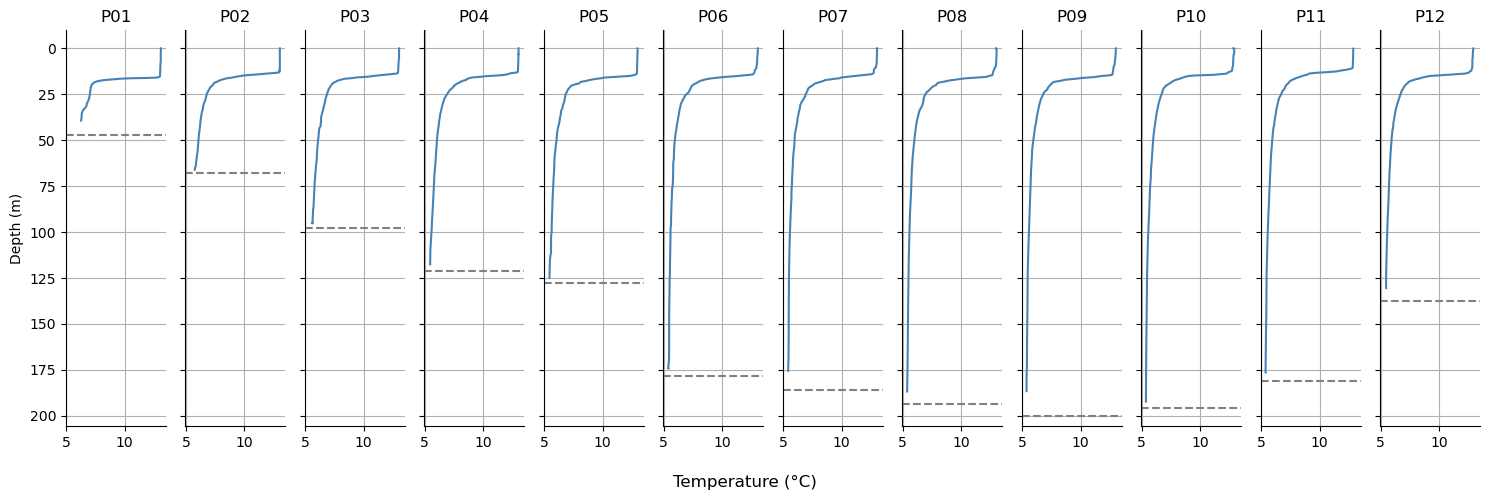

In [273]:
plot_profiles(data, 'depth', 'temp', 'steelblue')

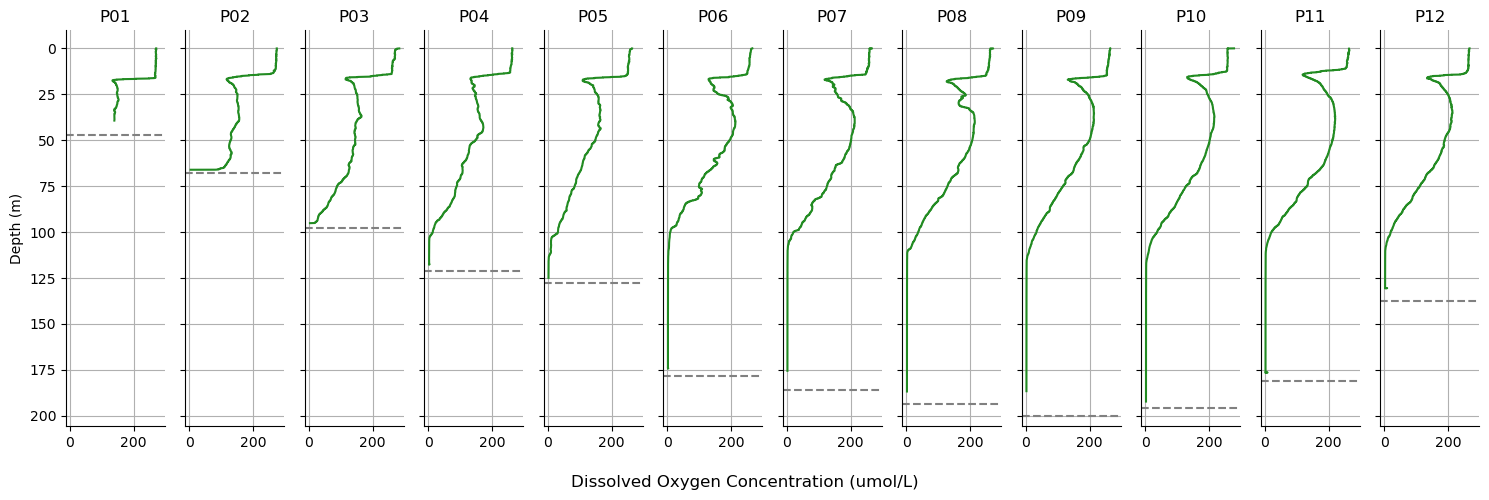

In [274]:
plot_profiles(data, 'depth', 'd_oxygen_conc', 'forestgreen')

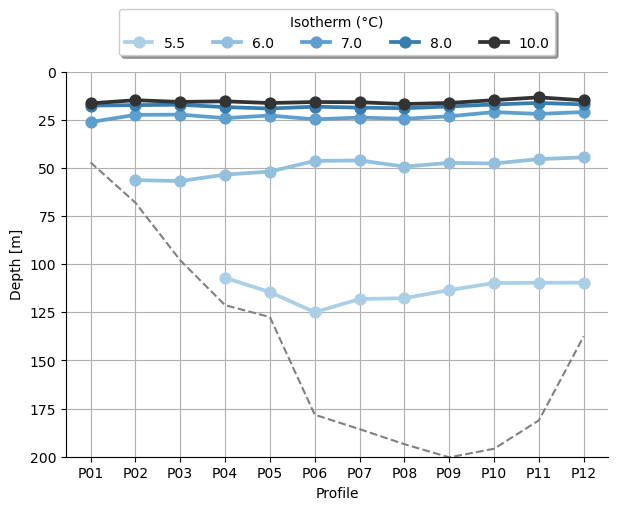

In [275]:
plot_isotherms(isot_data, 'depth')

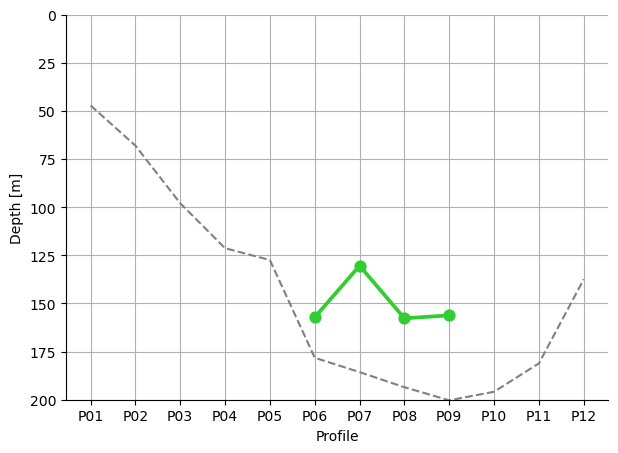

In [276]:
plot_anoxia(anoxia_data, 'depth')

In [277]:
inv_data.query("temp_diff >= 0.01 and hypolimnion == True")

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
53,4,P05,108.716217,111.220230,2.504013,5.564636,5.575479,0.010842,15.321525,True
57,5,P06,58.596416,60.591862,1.995445,5.851680,5.864554,0.012874,15.336688,True


#### 07.11.2025

In [278]:
md_files, profiles = locate_files(root, data_dirs[1], 'TOB')
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['temp'], dat['press'], window=1)
    inv = find_temp_inversions(temp_ra, dat['press'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)
isot_data = calculate_isotherms(data, 'press', [10, 8, 7, 6, 5.5])
anoxia_data = calculate_anoxia(data, 'press')

0it [00:00, ?it/s]

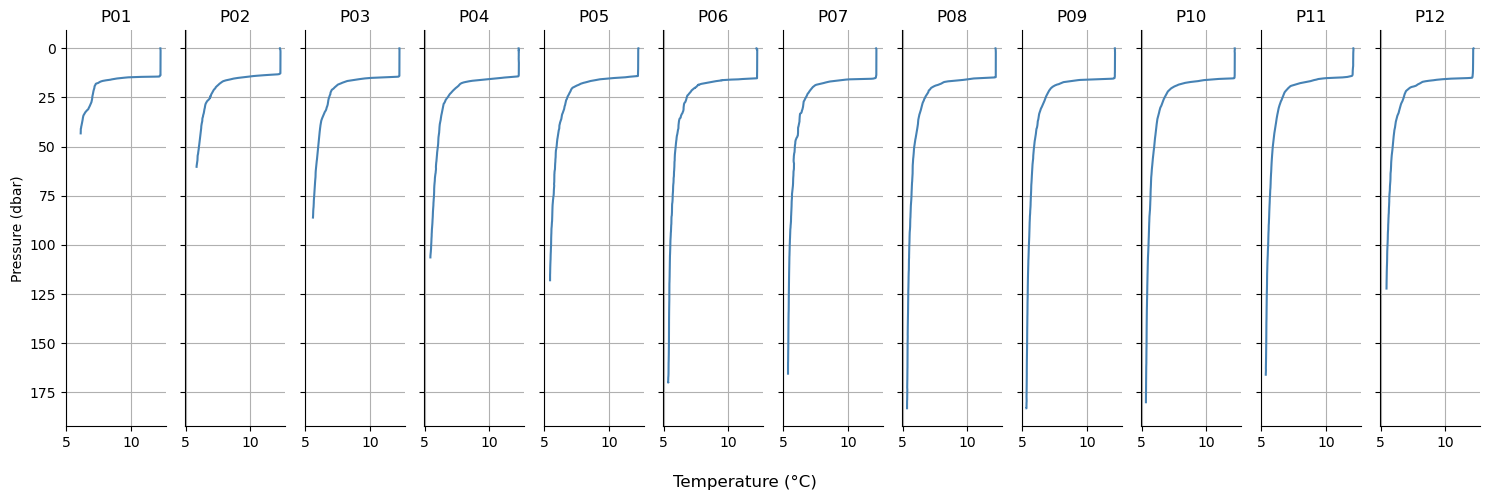

In [279]:
plot_profiles(data, 'press', 'temp', 'steelblue')

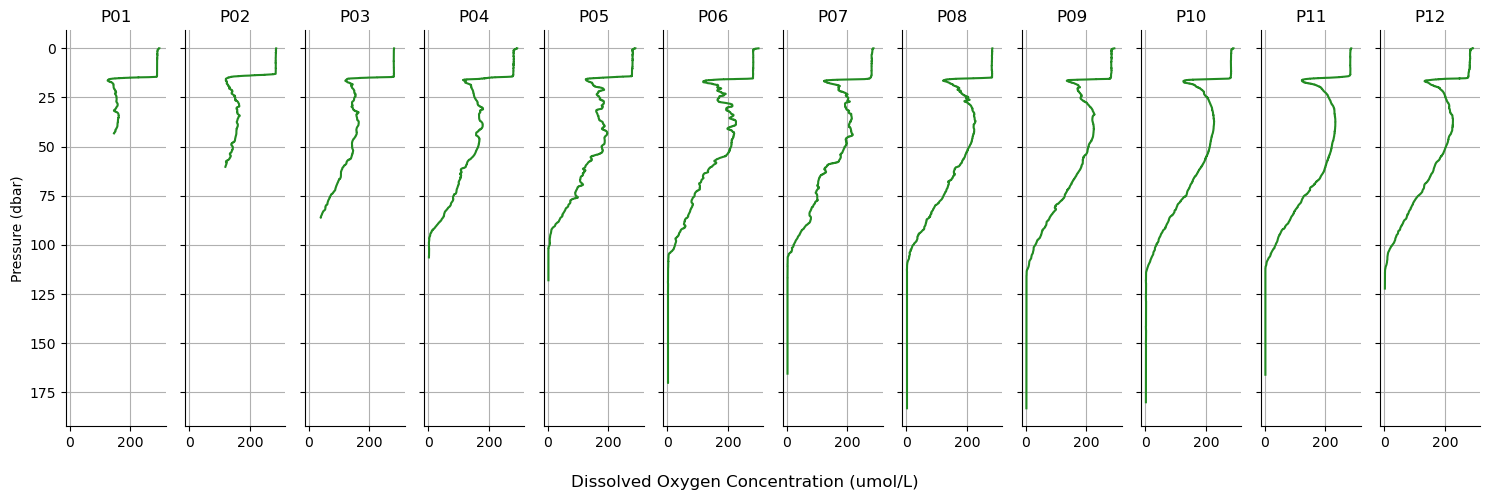

In [280]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')

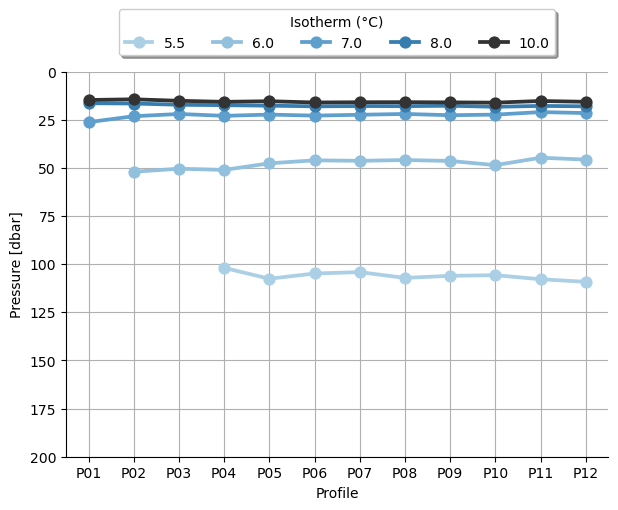

In [281]:
plot_isotherms(isot_data, 'press')

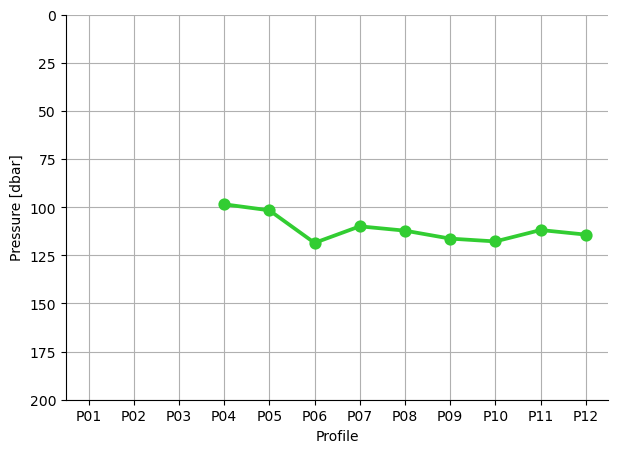

In [282]:
plot_anoxia(anoxia_data, 'press')

In [283]:
inv_data.query("temp_diff >= 0.01 and hypolimnion == True")

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
274,6,P07,57.1974,62.3333,5.1359,5.815173,5.845765,0.030592,15.6578,True


#### 14.11.2025

In [284]:
md_files, profiles = locate_files(root, data_dirs[2], 'TOB')
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['temp'], dat['press'], window=1)
    inv = find_temp_inversions(temp_ra, dat['press'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)
isot_data = calculate_isotherms(data, 'press', [10, 8, 7, 6, 5.5])
anoxia_data = calculate_anoxia(data, 'press')

0it [00:00, ?it/s]

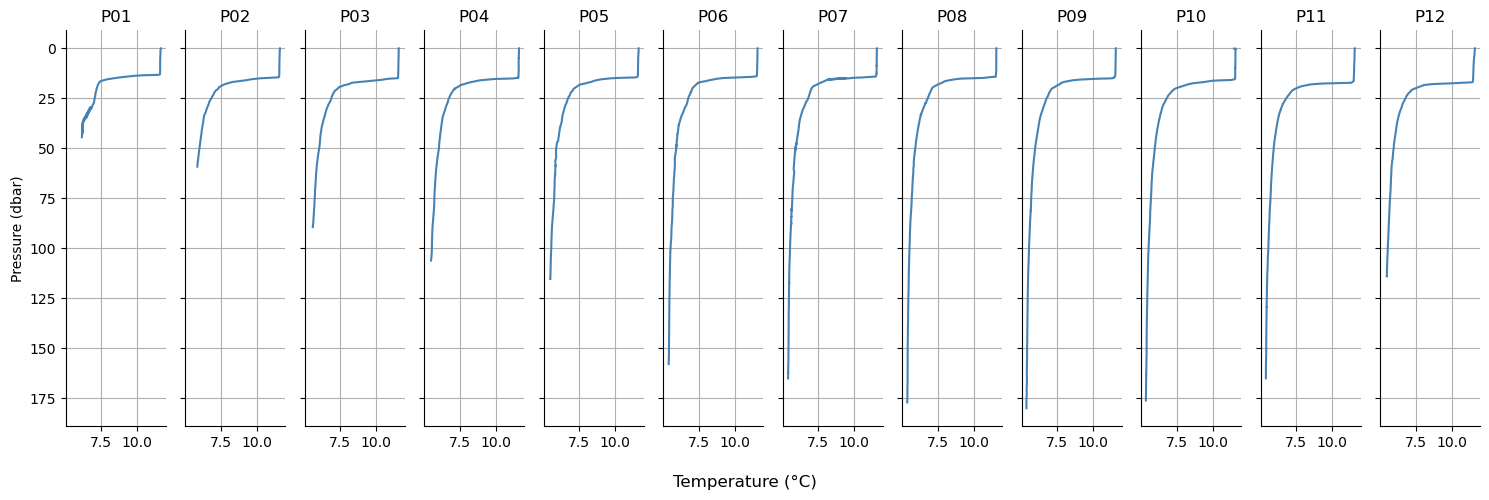

In [285]:
plot_profiles(data, 'press', 'temp', 'steelblue')

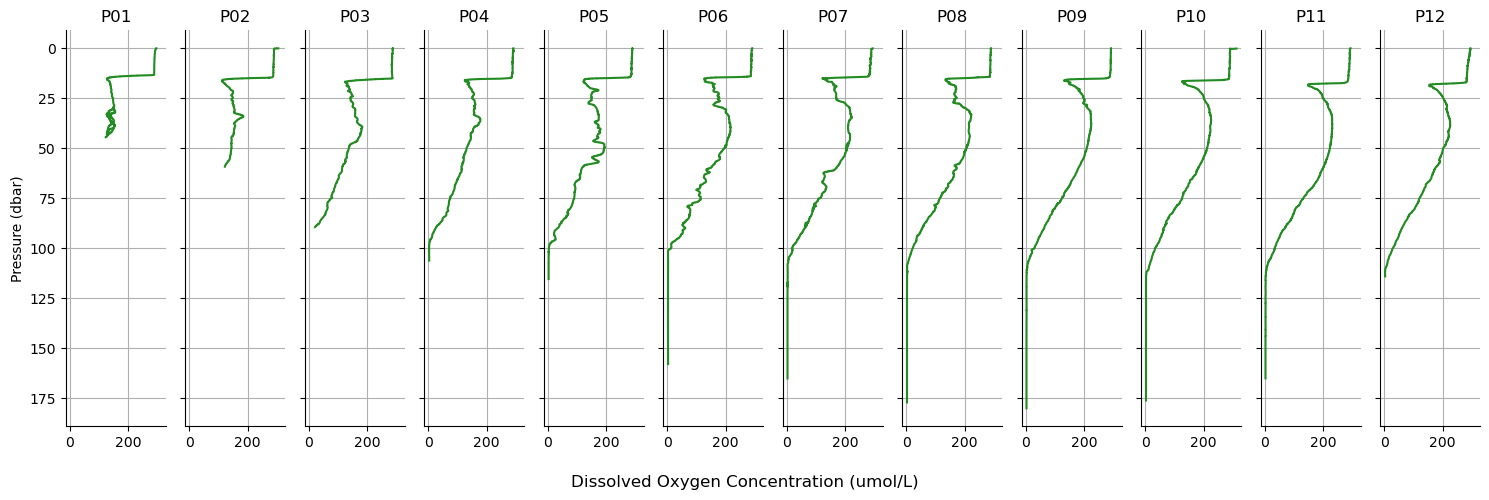

In [286]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')

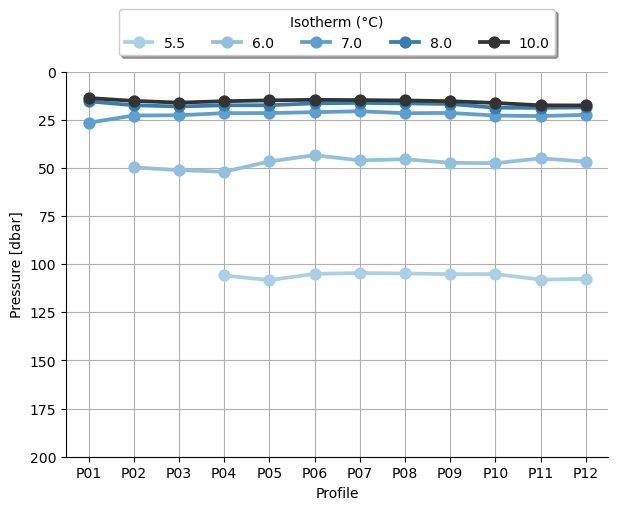

In [287]:
plot_isotherms(isot_data, 'press')

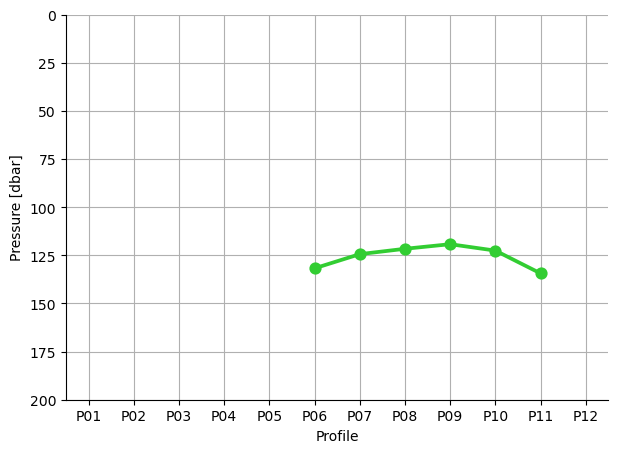

In [288]:
plot_anoxia(anoxia_data, 'press')

In [289]:
inv_data.query('temp_diff >= 0.01 and hypolimnion == True')

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
8,0,P01,42.8537,42.9171,0.0634,6.158581,6.819333,0.660753,13.6960,True
248,3,P04,20.3030,20.3136,0.0106,7.131236,7.151125,0.019888,15.1444,True
277,4,P05,52.2988,54.8784,2.5796,5.867422,5.885591,0.018169,14.5890,True
278,4,P05,56.8062,61.3357,4.5295,5.816226,5.839641,0.023415,14.5890,True
314,5,P06,17.2716,17.2822,0.0106,7.468754,7.485746,0.016991,14.4483,True
437,6,P07,15.8125,15.8300,0.0175,8.283217,9.368635,1.085418,14.3640,True
443,6,P07,50.9703,50.9880,0.0177,5.884180,5.964251,0.080072,14.3640,True
445,6,P07,60.1829,64.9034,4.7205,5.777997,5.818133,0.040137,14.3640,True
455,6,P07,81.3486,81.3733,0.0247,5.632829,5.645297,0.012469,14.3640,True
460,6,P07,89.2724,89.2971,0.0247,5.586574,5.601104,0.014530,14.3640,True


#### 21.11.2025

In [290]:
md_files, profiles = locate_files(root, data_dirs[3], 'TOB')
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)
inv_data = []
for i, dat in data.items():
    temp_ra = rolling_average(dat['temp'], dat['press'], window=1)
    inv = find_temp_inversions(temp_ra, dat['press'], i, dat['name'])
    inv_data.append(inv)
inv_data = pd.concat(inv_data, ignore_index=True)
isot_data = calculate_isotherms(data, 'press', [10, 8, 7, 6, 5.5])
anoxia_data = calculate_anoxia(data, 'press')

0it [00:00, ?it/s]

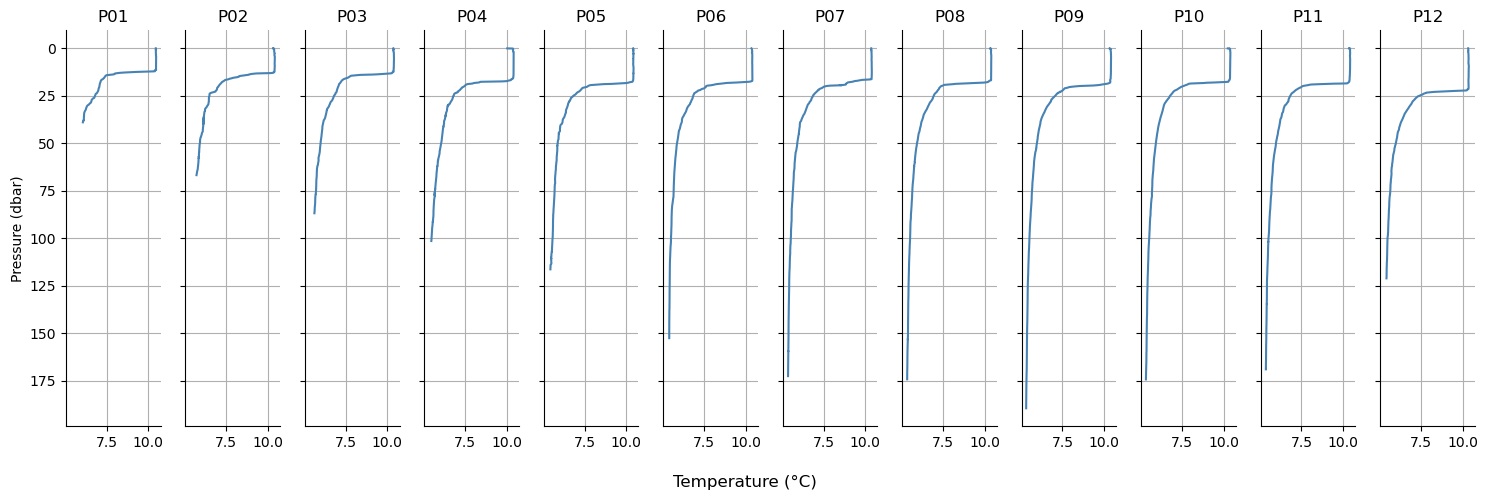

In [291]:
plot_profiles(data, 'press', 'temp', 'steelblue')

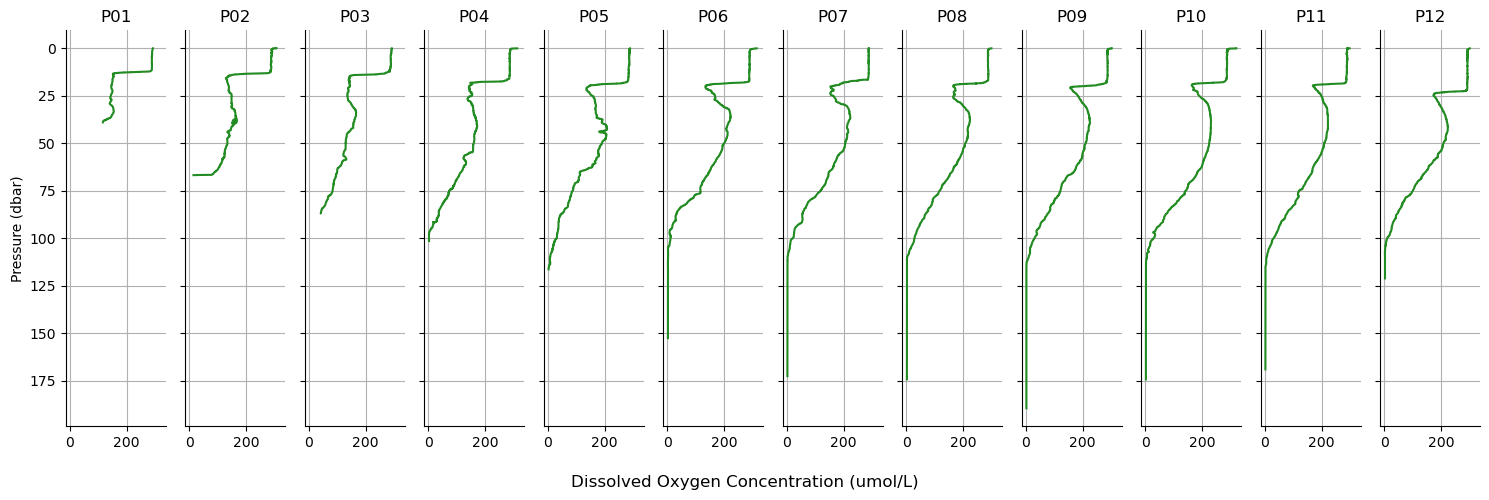

In [292]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')

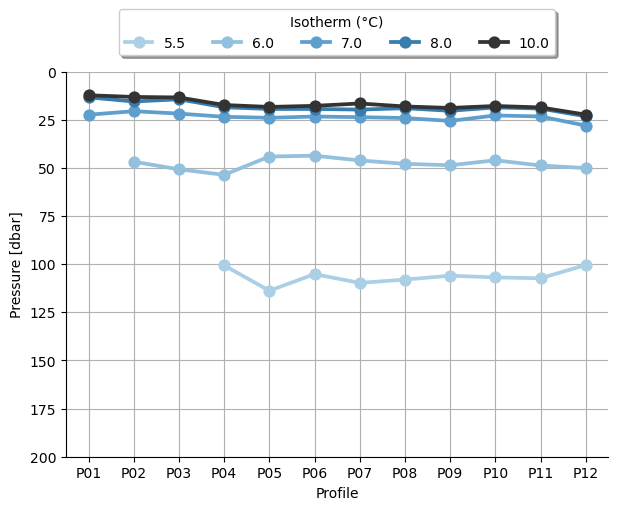

In [293]:
plot_isotherms(isot_data, 'press')

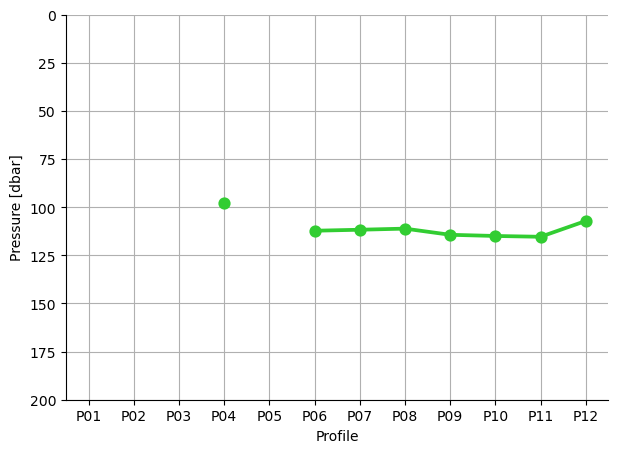

In [294]:
plot_anoxia(anoxia_data, 'press')

In [295]:
inv_data.query("temp_diff >= 0.01 and hypolimnion == True")

,idx,profile,depth_start,depth_end,depth_range,temp_min,temp_max,temp_diff,thermocline_depth,hypolimnion
149,1,P02,39.9377,40.0151,0.0774,6.145943,6.182752,0.036809,13.1406,True
194,3,P04,22.9446,22.9763,0.0317,7.040539,7.056884,0.016345,17.6092,True
195,3,P04,23.4582,23.5145,0.0563,6.939735,6.963192,0.023456,17.6092,True
199,3,P04,29.7987,29.8656,0.0669,6.502876,6.515062,0.012186,17.6092,True
200,3,P04,30.3443,30.4076,0.0633,6.464612,6.475960,0.011348,17.6092,True
260,4,P05,19.3675,19.4449,0.0774,7.977671,7.990560,0.012889,18.1015,True
312,4,P05,110.0082,113.4705,3.4623,5.510805,5.522076,0.011271,18.1015,True
